# Investigating the topics in SFA lyrics

TODO - add custom NLP pipeline in Spacy (move function to shared module)
Also wordcould or each alsbum
Compare with Tom Jones!

In [1]:
import pandas as pd
import textacy
import spacy
import string
import re
from spacy.lang.en.stop_words import STOP_WORDS

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from spacy_pipeline_functions import remove_parts, remove_stopwords


from os import path
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np

nlp = spacy.load('en')
% matplotlib inline

Load the lyrics of all english language songs from a studio album. Also crteate a 'metadata' string - basiclly a string representation of json or dict that we will use later to identify each song as it is transformed into a spaCy doc.

In [47]:
lyrics = pd.read_csv("data/SFALyrics.csv", dtype=str)
lyrics = lyrics[['lyrics', 'title', 'album']]
lyrics = lyrics[pd.notnull(lyrics['title'])]
lyrics['lyrics'] = lyrics['lyrics'].replace('\n',' ', regex=True)
lyrics['lyrics'] = lyrics['lyrics'].str.lower()
lyrics.loc[lyrics['album'] == 'Dark Day/Light Years', 'album'] = 'Dark Days/Light Years'
lyrics.loc[lyrics['album'] == 'Gorilla', 'album'] = 'Guerilla'
lyrics['metadata'] = '{"title": "' + lyrics['title'] + '" ,"album":"' + lyrics['album'] + '"}'

lyrics.head()

,lyrics,title,album,metadata
0,i had a soul transplant operation coz my bypa...,God! How me magic,Fuzzy Logic,"{""title"": ""God! How me magic"" ,""album"":""Fuzzy ..."
1,"[bunf:] hamster, turnin' round in your wheel ...",Fuzzy Birds,Fuzzy Logic,"{""title"": ""Fuzzy Birds"" ,""album"":""Fuzzy Logic""}"
2,"first time, i did it for the hell of it stuck...",Something 4 the weekend,Fuzzy Logic,"{""title"": ""Something 4 the weekend"" ,""album"":""..."
3,locked in a sorry dream you know we're drowni...,Frisbee,Fuzzy Logic,"{""title"": ""Frisbee"" ,""album"":""Fuzzy Logic""}"
4,i was lost lost on the bypass road could be ...,Hometown Unicorm,Fuzzy Logic,"{""title"": ""Hometown Unicorm"" ,""album"":""Fuzzy L..."


## Pre-process text

In [3]:
nlp.pipeline

[('tagger', <spacy.pipeline.Tagger at 0x1a1658a208>),
 ('parser', <spacy.pipeline.DependencyParser at 0x1a165de2b0>),
 ('ner', <spacy.pipeline.EntityRecognizer at 0x1a165de360>)]

In [4]:
nlp.add_pipe(remove_parts, 'rm_parts',  after ='tagger')

In [5]:
nlp.pipeline

[('tagger', <spacy.pipeline.Tagger at 0x1a1658a208>),
 ('rm_parts',
  <function spacy_pipeline_functions.remove_parts(doc, stop=True, punct=True, num=True, digit=True, currency=True, url=True, email=True)>),
 ('parser', <spacy.pipeline.DependencyParser at 0x1a165de2b0>),
 ('ner', <spacy.pipeline.EntityRecognizer at 0x1a165de360>)]

Lets have a look customising the stopword list

In [19]:
nlp.vocab["be"].is_stop = True
nlp.vocab["are"].is_stop = True
nlp.vocab["go"].is_stop = True
nlp.vocab["will"].is_stop = True
nlp.vocab["\n"].is_stop = True
nlp.vocab["'re"].is_stop = True
nlp.vocab["n't"].is_stop = True
nlp.vocab[""].is_stop = True

Now, lets create a spaCy doument from each song lyric

In [20]:
lyrics['doc'] = lyrics['lyrics'].apply(nlp)
lyrics.head()

,lyrics,title,album,metadata,doc
0,i had a soul transplant operation \ncoz my byp...,God! How me magic,Fuzzy Logic,"{""title"": ""God! How me magic"" ,""album"":""Fuzzy ...","(soul, transplant, operation, coz, bypass, fun..."
1,"[bunf:] \nhamster, turnin' round in your wheel...",Fuzzy Birds,Fuzzy Logic,"{""title"": ""Fuzzy Birds"" ,""album"":""Fuzzy Logic""}","(bunf, hamster, turnin, round, wheel, 've, got..."
2,"first time, i did it for the hell of it \nstuc...",Something 4 the weekend,Fuzzy Logic,"{""title"": ""Something 4 the weekend"" ,""album"":""...","(time, hell, stuck, tongue, swallowed, second,..."
3,locked in a sorry dream \nyou know we're drown...,Frisbee,Fuzzy Logic,"{""title"": ""Frisbee"" ,""album"":""Fuzzy Logic""}","(locked, sorry, dream, know, drowning, designe..."
4,i was lost \nlost on the bypass road \ncould b...,Hometown Unicorm,Fuzzy Logic,"{""title"": ""Hometown Unicorm"" ,""album"":""Fuzzy L...","(lost, lost, bypass, road, worse, turned, toad..."


In [22]:
sents = list(lyrics['doc'][0].sents)
sents[0]

soul transplant operation coz bypass function 'm keeping toes til man 

 magic magic magic mad 

 nice know paper tv hamster 's ate today 

 magic magic magic mad 

 god magic god magic god magic god mad 

 magic magic magic magic

## Create a corpus
A corpus is an ordered collection of textacy Docs, all processed by the same spacy language pipeline. We can convert our dataframe of documents into a corpus, using our json string as metadata.

In [9]:
corpus = textacy.Corpus(nlp, docs=list(lyrics['doc']), metadatas= list(lyrics['metadata']))

In [23]:
print("This corpus has {} documents, {} sentances and {} tokens".format(corpus.n_docs, corpus.n_sents, corpus.n_tokens))

This corpus has 83 documents, 363 sentances and 7382 tokens


### Usuing Corpus we can still access details about each doument
Each document is a song, so lets get the details from each, usuing the lyrics themselves and any metadata.
The metatdata is stored as a dict string - or json - so needs to be intepretted

In [24]:
import json
n = 45
doc = corpus[n]
d = json.loads(doc.metadata.replace("'", "\""))
ts = textacy.TextStats(doc)
print("{} from the album {} has {} unique words".format(d['title'], d['album'], ts.n_unique_words))

Liberty Belle from the album Phantom Power has 64 unique words


## Topic Analysis
We can vectorise and transform the corpus ready for further statitical models.

In [25]:
vectorizer = textacy.Vectorizer(
    tf_type='linear', apply_idf=True, idf_type='smooth', norm='l2',
    min_df=2, max_df=0.95)

In [26]:
doc_term_matrix = vectorizer.fit_transform(
    (doc.to_terms_list(ngrams=1, named_entities=True, as_strings=True)
        for doc in corpus))

print(repr(doc_term_matrix))

<83x511 sparse matrix of type '<class 'numpy.float64'>'
	with 2113 stored elements in Compressed Sparse Row format>


Lets apply a model to analyse the key topics in the corpus. Lets use NMF and assume 5 topics.

In [27]:
model = textacy.tm.TopicModel('nmf', n_topics=5)
model.fit(doc_term_matrix)
model

TopicModel(n_topics=5, model=NMF)

Lets view the top words that the model has found:

In [29]:
doc_topic_matrix = model.transform(doc_term_matrix)
for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term):
     print('topic', topic_idx, ':', ', '.join(top_terms))

topic 0 : have, get, , know, away, time, be, far, need, go
topic 1 : la, space, long, go, door, school, house, gon, open, na
topic 2 : come, take, feel, count, thing, twinkle, toe, away, sympathy, gather
topic 3 : people, mountain, one, will, freeze, deep, not, friend, stay, lie
topic 4 : hand, jump, baby, break, stand, world, girl, be, clone, boy


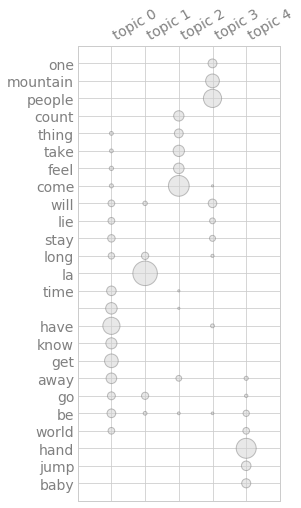

In [16]:
model.termite_plot(doc_term_matrix, vectorizer.id_to_term,
                   topics=-1,  n_terms=25, sort_terms_by='seriation')

## WordCloud based off all lyrics

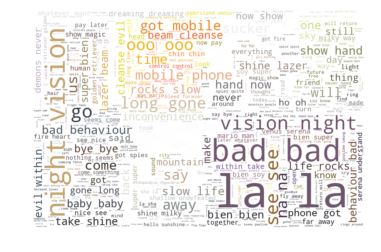

In [35]:
text = lyrics['lyrics'].str.cat(sep=' ')

mask = np.array(Image.open("images/fuzzy-logic-sfa.jpg"))

wordcloud_usa = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(text)

# create coloring from image
image_colors = ImageColorGenerator(mask)

plt.imshow(wordcloud_usa.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# store to file
plt.savefig("images/lyrics.png", format="png", bbox_inches="tight")

plt.show()

## Generate a word cloud for each album

In [48]:
# split the 

albums1 = dict(tuple(lyrics.groupby('album')))

albums2 = lyrics.groupby('album')
print(albums2)

for album in albums2:
    print(album)
    album['lyrics'].cat(sep=' ')
    mask = np.array(Image.open("images/fuzzy-logic-sfa.jpg"))
    wordcloud_usa = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(text)
    # create coloring from image
    image_colors = ImageColorGenerator(mask)

    plt.imshow(wordcloud_usa.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.show()

('Dark Days/Light Years',                                                 lyrics  \
173  take no shit, you gotta get a grip take the ri...   
174  i wasn't looking for a mountain  there was the...   
175  hot clubs and endless nights  hot clubs and en...   
176  trams  inaugral trams  trams  inaugral trams  ...   
177  inconvenience, what the fuck!?  inconvenience,...   
178  we took the porsche down to tiger bay  drank t...   
179  just the very thought, trust but verify   the ...   
180  got my nose nose nose to smell the ground  eye...   
181  i look like a loser coming from the gutter  wa...   
182  where do you wanna go?  'cos we could go anywh...   

                             title                  album  \
173             Crazy Naked Girls   Dark Days/Light Years   
174                             Mt  Dark Days/Light Years   
175                     Moped Eyes  Dark Days/Light Years   
176                Inaugural Trams  Dark Days/Light Years   
177                 Inconvieni

TypeError: tuple indices must be integers or slices, not str